# Power AutoCorrelation Strategy

This model is based on the German power auto-correlation strategy proposed by [Narro, J., and M. Caamano. Systematic Trading in Energy Markets. London, UK: Risk Books, 2020.]
Adding the constraint of long only, an end-of-day buy signal is generated using a simple rule: If the difference in price from yesterday’s close to today’s is positive,then go long at today’s close, else exit the position.
$$y_{t} = 
\begin{cases}
1, & \quad \text{if $\Delta r_{t} > 0$}\\
y_{t-1}, & \quad \text{if $\Delta r_{t} = 0$}\\
0, & \quad \text{if $\Delta r_{t} < 0$}
\end{cases} 
$$
where $y_{t}$ is the side of position, $y_{t} \in {0, 1}$, and $\Delta r_{t}$ is the difference in returns between  $r_{t} - r_{t-1}$.

[Jacques Francois Joubert, Meta-Labeling: Theory and  Framework, 2022]


In [4]:
from datetime import datetime

from hgraph.notebook import start_wiring_graph
from matplotlib import pyplot as plt

from hg_systematic.data.generators import auto_regressive_generator, white_noise_generator

In [2]:
start_wiring_graph("power_autocorrelation_strategy", start_time=datetime(2023, 1, 1), end_time=datetime(2024, 1, 1))

In [5]:
noise = white_noise_generator()

In [10]:
values = noise.eval()
data = {"date": [v[0] for v in values], "value": [v[1] for v in values]}

2024-11-02 10:13:02,895 [hgraph][DEBUG] Creating graph engine: EvaluationMode.SIMULATION
2024-11-02 10:13:02,896 [hgraph][DEBUG] Starting to run graph from: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
2024-11-02 10:13:02,896 [hgraph][WARNING] /Users/hhenson/PycharmProjects/hg_systematic/.venv/lib/python3.12/site-packages/hgraph/_impl/_runtime/_evaluation_clock.py:54: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
2024-11-02 10:13:02,900 [hgraph][DEBUG] Finished running graph


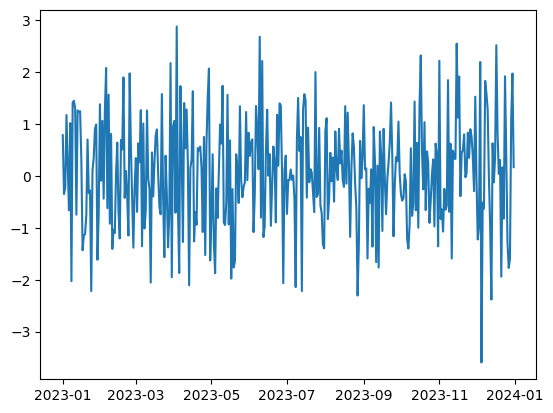

In [11]:
plt.plot(data["date"], data["value"])

In [18]:
returns = auto_regressive_generator(noise, order=3, initial_values=(0.032, 0.02, -0.042),
                                    coefficients=(-0.0001, -0.25, 0.2, -0.35))

In [19]:
values = returns.eval()
returns_data = {"date": [v[0] for v in values], "value": [v[1] for v in values]}

2024-11-02 10:43:19,133 [hgraph][DEBUG] Creating graph engine: EvaluationMode.SIMULATION
2024-11-02 10:43:19,134 [hgraph][DEBUG] Starting to run graph from: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
2024-11-02 10:43:19,134 [hgraph][WARNING] /Users/hhenson/PycharmProjects/hg_systematic/.venv/lib/python3.12/site-packages/hgraph/_impl/_runtime/_evaluation_clock.py:54: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
2024-11-02 10:43:19,145 [hgraph][DEBUG] Finished running graph


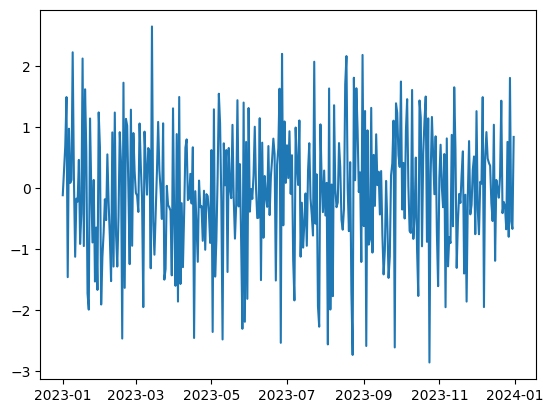

In [20]:
plt.plot(returns_data["date"], returns_data["value"])